In [1]:
import sys
import re
import numpy as np
import pandas as pd
import seaborn as sns
import liwc
from matplotlib import pyplot as plt

from collections import defaultdict, Counter


sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')

from src.features.collect_samples import get_non_political_samples, get_political_samples, get_bad_actor_samples
from src.features.collect_user_features import read_in_non_pol_user_features, read_in_pol_user_features, read_in_bad_actor_features
from src.features.political_affiliations.conglomerate_affiliations import get_all_political_users
from src.features.bad_actors.bad_actors import read_in_bad_actor_usernames

### Read in the sample submissions from each group 

In [23]:
non_pol_df = get_non_political_samples()
pol_df = get_political_samples()
bad_actors_df = get_bad_actor_samples()

# # We changed filter criteria after collecting some of this data
# # Verify the political users and bad actors are up to date
# pol_users = get_all_political_users()
# bad_actors = get_bad_actors_90_days_1_flip_flop()

# pol_df = pol_df[pol_df['username'].isin(pol_users)]
# bad_actors_df = bad_actors_df[bad_actors_df['username'].isin(bad_actors)]


def random_df_sample(df, n):
    df_shuffled = df.sample(frac=1).reset_index(drop=True)
    return df_shuffled.iloc[:n]
    
print("Grabbing random 10k sample from each data source")
pol_sample = random_df_sample(pol_df, n=20000)
non_pol_sample = random_df_sample(non_pol_df, n=20000)
bad_actor_sample = random_df_sample(bad_actors_df, n=20000)

Grabbing random 10k sample from each data source


In [24]:
pol_words = " ".join(pol_sample['text'].tolist())
non_pol_words = " ".join(non_pol_sample['text'].tolist())
bad_actor_words = " ".join(bad_actor_sample['text'].tolist())

print("Number of political words: {}".format(len(pol_words.split(" "))))
print("Number of non-political words: {}".format(len(non_pol_words.split(" "))))
print("Number of bad actor words: {}".format(len(bad_actor_words.split(" "))))

Number of political words: 460988
Number of non-political words: 652873
Number of bad actor words: 1069940


# LIWC Category Analysis

In [25]:
parse, category_names = liwc.load_token_parser('/shared/0/resources/liwc/LIWC2015_English.dic')

def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

In [26]:
pol_counts = Counter(category for token in pol_words for category in parse(token))
for k, v in pol_counts.items():
    print(k, v)

function (Function Words) 374967
pronoun (Pronouns) 215670
ppron (Personal Pronouns) 215670
you (You) 65256
informal (Informal Language) 395513
netspeak (Netspeak) 395513
article (Articles) 159297
assent (Assent) 20792
i (I) 150414


In [27]:
non_pol_counts = Counter(category for token in non_pol_words for category in parse(token))
for k, v in non_pol_counts.items():
    print(k, v)

function (Function Words) 539644
article (Articles) 230630
informal (Informal Language) 569869
netspeak (Netspeak) 569869
pronoun (Pronouns) 309014
ppron (Personal Pronouns) 309014
you (You) 94010
i (I) 215004
assent (Assent) 30762


In [28]:
bad_actor_counts = Counter(category for token in bad_actor_words for category in parse(token))
for k, v in bad_actor_counts.items():
    print(k, v)

informal (Informal Language) 1142806
netspeak (Netspeak) 1142806
function (Function Words) 1009514
article (Articles) 435233
pronoun (Pronouns) 574281
ppron (Personal Pronouns) 574281
i (I) 388441
you (You) 185840
assent (Assent) 51625


## Categories as Percentages

In [32]:
total_pol_words = np.sum(list(pol_counts.values()))
total_non_pol_words = np.sum(list(non_pol_counts.values()))
total_bad_actor_words = np.sum(list(bad_actor_counts.values()))

def compute_category_percentages(total_words, category_counts, source):
    rows = []
    for category, count in category_counts.items():
        entry = {'Category': category, 'Percentage': count / total_words, 'Source': source}
        rows.append(entry)
    return rows

rows = []
rows.extend(compute_category_percentages(total_pol_words, pol_counts, 'Political'))
rows.extend(compute_category_percentages(total_non_pol_words, non_pol_counts, 'Non-Political'))
rows.extend(compute_category_percentages(total_bad_actor_words, bad_actor_counts, 'Bad Actors'))

categories_df = pd.DataFrame(rows, columns=['Category', 'Percentage', 'Source'])
categories_df.head()

,Category,Percentage,Source
0,function (Function Words),0.188133,Political
1,pronoun (Pronouns),0.108209,Political
2,ppron (Personal Pronouns),0.108209,Political
3,you (You),0.032741,Political
4,informal (Informal Language),0.198442,Political
5,netspeak (Netspeak),0.198442,Political
6,article (Articles),0.079925,Political
7,assent (Assent),0.010432,Political
8,i (I),0.075468,Political
9,function (Function Words),0.188172,Non-Political


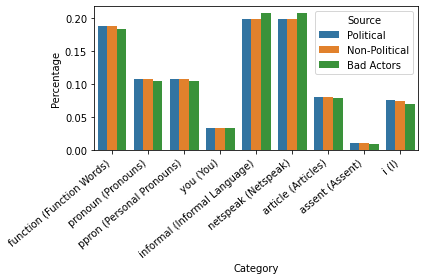

In [33]:
ax = sns.barplot(x="Category", y="Percentage", hue="Source", data=categories_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### Bootstrap Confidence Intervals

In [49]:
n_iters = 100
sample_size = 5000 

p_bootstrap_samples, np_bootstrap_samples, ba_bootstrap_samples = [], [], []

rows = []

for i in range(n_iters):
    
    pol_sample = random_df_sample(pol_df, n=sample_size)
    pol_sample_words = " ".join(pol_sample['text'].tolist())
    pol_sample_counts = Counter(category for token in pol_sample_words for category in parse(token))
    total_pol_sample_words = np.sum(list(pol_sample_counts.values()))
    
    non_pol_sample = random_df_sample(non_pol_df, n=sample_size)
    non_pol_sample_words = " ".join(non_pol_sample['text'].tolist())
    non_pol_sample_counts = Counter(category for token in non_pol_sample_words for category in parse(token))
    total_non_pol_sample_words = np.sum(list(non_pol_sample_counts.values()))
    
    bad_actors_sample = random_df_sample(bad_actors_df, n=sample_size)
    bad_actors_sample_words = " ".join(bad_actors_sample['text'].tolist())
    bad_actors_sample_counts = Counter(category for token in bad_actors_sample_words for category in parse(token))
    total_bad_actors_sample_words = np.sum(list(bad_actors_sample_counts.values()))
    
    rows.extend(compute_category_percentages(total_pol_sample_words, pol_sample_counts, 'Political'))
    rows.extend(compute_category_percentages(total_non_pol_sample_words, non_pol_sample_counts, 'Non-Political'))
    rows.extend(compute_category_percentages(total_bad_actors_sample_words, bad_actors_sample_counts, 'Bad Actors'))
    
    
bs_categories_df = pd.DataFrame(rows, columns=['Category', 'Percentage', 'Source'])
bs_categories_df.head()

,Category,Percentage,Source
0,informal (Informal Language),0.198387,Political
1,netspeak (Netspeak),0.198387,Political
2,function (Function Words),0.187876,Political
3,pronoun (Pronouns),0.108545,Political
4,ppron (Personal Pronouns),0.108545,Political


In [50]:
combined_df = pd.concat([categories_df, bs_categories_df], ignore_index=True)
combined_df.head(15)

,Category,Percentage,Source
0,function (Function Words),0.188133,Political
1,pronoun (Pronouns),0.108209,Political
2,ppron (Personal Pronouns),0.108209,Political
3,you (You),0.032741,Political
4,informal (Informal Language),0.198442,Political
5,netspeak (Netspeak),0.198442,Political
6,article (Articles),0.079925,Political
7,assent (Assent),0.010432,Political
8,i (I),0.075468,Political
9,function (Function Words),0.188172,Non-Political


In [51]:
print(len(combined_df))

2727


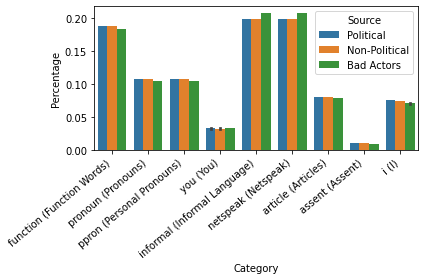

In [53]:
ax = sns.barplot(x="Category", y="Percentage", hue="Source", data=combined_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# LDA On Sample Submissions

# Log Odds Visualization?